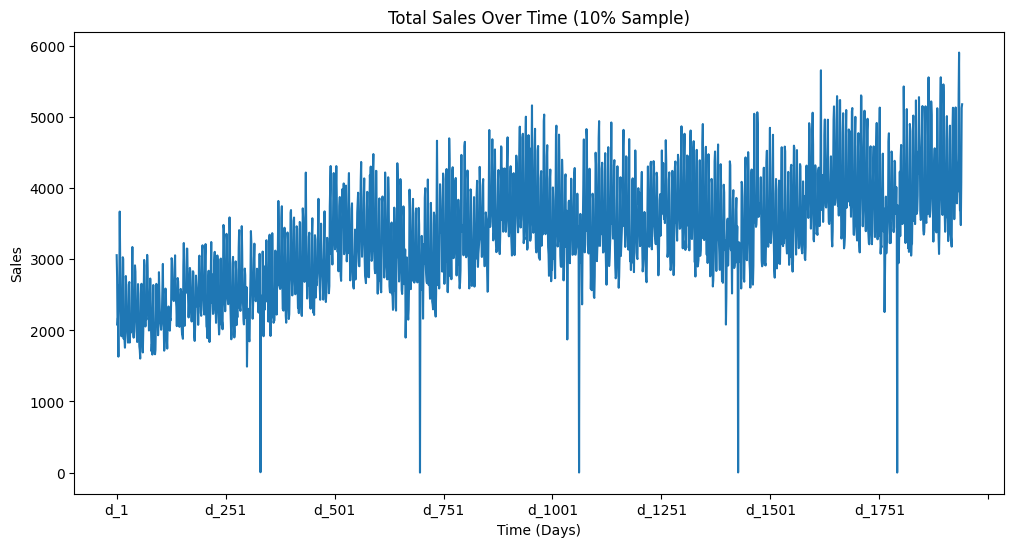

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Load the datasets
calendar = pd.read_csv('C:\\Users\\ryanb\\Downloads\\m5-forecasting-accuracy\\calendar.csv')
sell_prices = pd.read_csv('C:\\Users\\ryanb\\Downloads\\m5-forecasting-accuracy\\sell_prices.csv')
sales_train = pd.read_csv('C:\\Users\\ryanb\\Downloads\\m5-forecasting-accuracy\\sales_train_evaluation.csv')

# Take a 10% sample of the 'sales_train' dataset
sales_train_sample = sales_train.sample(frac=.1, random_state=42)

# Ensure no missing values
sales_train_sample.fillna(0, inplace=True)

# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12,6))
sales_train_sample.iloc[:, 6:].sum(axis=0).plot()
plt.title('Total Sales Over Time (10% Sample)')
plt.xlabel('Time (Days)')
plt.ylabel('Sales')
plt.show()

In [108]:
# 1. Feature Engineering: Create lag features and total sales
# Create 'total_sales' column by summing sales across all products
sales_train_sample['total_sales'] = sales_train_sample.iloc[:, 6:].sum(axis=1)

# Create a lag feature for total sales
sales_train_sample['lag_1'] = sales_train_sample['total_sales'].shift(1)
sales_train_sample['lag_7'] = sales_train_sample['total_sales'].shift(7)
sales_train_sample['lag_14'] = sales_train_sample['total_sales'].shift(14)
# Add more lag features (e.g., 30, 60, 90 days)
sales_train_sample['lag_30'] = sales_train_sample['total_sales'].shift(30)
sales_train_sample['lag_60'] = sales_train_sample['total_sales'].shift(60)
sales_train_sample['lag_90'] = sales_train_sample['total_sales'].shift(90)


# Fill any missing values resulting from the shift
sales_train_sample.fillna(0, inplace=True)

Training data size: 2439, Test data size: 610


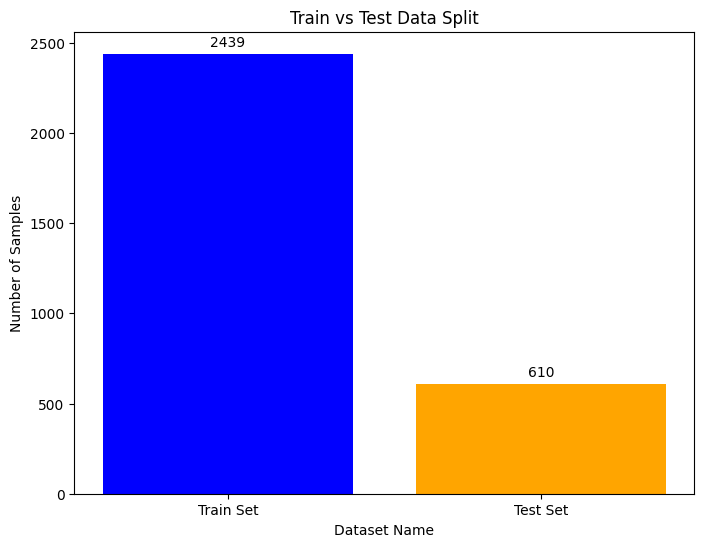

In [131]:
# 2. Train-Test Split
# Since this is a time-series problem, we will do a time-based split
train_size = int(len(sales_train_sample) * 0.8)
train_data_sample = sales_train_sample[:train_size]
test_data_sample = sales_train_sample[train_size:]

# Ensure the split sizes are correct
print(f"Training data size: {len(train_data_sample)}, Test data size: {len(test_data_sample)}")
# Assuming you have train_data_sample and test_data_sample already split
train_size = len(train_data_sample)
test_size = len(test_data_sample)

# Dataset names and corresponding sizes
datasets = ['Train Set', 'Test Set']
sizes = [train_size, test_size]

# Create a bar chart to display the train-test split
plt.figure(figsize=(8, 6))
plt.bar(datasets, sizes, color=['blue', 'orange'])

# Add labels and title
plt.title('Train vs Test Data Split')
plt.xlabel('Dataset Name')
plt.ylabel('Number of Samples')

# Annotate bars with dataset sizes
for i, v in enumerate(sizes):
    plt.text(i, v + 0.01 * max(sizes), str(v), ha='center', va='bottom')

# Show the plot
plt.show()

In [110]:
# Import necessary statsmodels for ARIMA
import statsmodels.api as sm

# Fit ARIMA model to training data (for simplicity, we aggregate sales over time)
model_arima = sm.tsa.ARIMA(train_data_sample['total_sales'], order=(5,1,0))
arima_result = model_arima.fit()

# Forecast using ARIMA for the test data period
arima_forecast = arima_result.forecast(steps=len(test_data_sample))

# Evaluate ARIMA Model
from sklearn.metrics import mean_squared_error
import numpy as np

# RMSE for ARIMA
rmse_arima = np.sqrt(mean_squared_error(test_data_sample['total_sales'], arima_forecast))
print(f'RMSE for ARIMA: {rmse_arima}')

C:\Users\ryanb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\ryanb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\ryanb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


RMSE for ARIMA: 13405.278331140942


C:\Users\ryanb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ryanb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [121]:
# 4. XGBoost Model

from xgboost import XGBRegressor

# Define features and target
X_train_xgb = train_data_sample[['lag_1']]  # Lagged sales feature for XGBoost
y_train_xgb = train_data_sample['total_sales']
X_test_xgb = test_data_sample[['lag_1']]
y_test_xgb = test_data_sample['total_sales']

# Initialize XGBoost model
xgb_model = XGBRegressor()

# Train XGBoost model
xgb_model.fit(X_train_xgb, y_train_xgb)

# Make predictions with XGBoost
xgb_forecast = xgb_model.predict(X_test_xgb)

# RMSE for XGBoost
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, xgb_forecast))
print(f'RMSE for XGBoost: {rmse_xgb}')

RMSE for XGBoost: 5385.373995011809


In [112]:
# 5. LSTM Model

# Import necessary libraries for LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Scaling the data for LSTM
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_data_sample[['total_sales', 'lag_1']])

# Prepare the data for LSTM (reshaping into 3D: [samples, timesteps, features])
X_train_lstm, y_train_lstm = train_scaled[:, 1].reshape(-1, 1, 1), train_scaled[:, 0]

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(1, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))

# Compile the LSTM model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32)

# Prepare test data for LSTM
test_scaled = scaler.transform(test_data_sample[['total_sales', 'lag_1']])
X_test_lstm = test_scaled[:, 1].reshape(-1, 1, 1)

# Predict using LSTM
lstm_forecast = lstm_model.predict(X_test_lstm)

# Inverse scale the forecast back to original scale
lstm_forecast = scaler.inverse_transform(np.concatenate([lstm_forecast, test_scaled[:, 1].reshape(-1, 1)], axis=1))[:, 0]

# RMSE for LSTM
rmse_lstm = np.sqrt(mean_squared_error(test_data_sample['total_sales'], lstm_forecast))
print(f'RMSE for LSTM: {rmse_lstm}')

Epoch 1/10


C:\Users\ryanb\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0028
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033  
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024  
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033  
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033  
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027  
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
RMSE for LSTM: 5168.845905678977


In [113]:
# 6. Model Performance Summary
print(f'\nModel Performance Summary (RMSE):')
print(f'ARIMA: {rmse_arima}')
print(f'XGBoost: {rmse_xgb}')
print(f'LSTM: {rmse_lstm}')


Model Performance Summary (RMSE):
ARIMA: 13405.278331140942
XGBoost: 5385.373995011808
LSTM: 5168.845905678977


In [114]:
#Hyperparameter tuning using gridsearch
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the parameter grid to search over
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Initialize the XGBoost regressor
xgb_model = XGBRegressor()

# Set up Grid Search with 3-fold cross-validation
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, 
                               cv=3, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search to the training data
grid_search_xgb.fit(X_train_xgb, y_train_xgb)

# Get the best hyperparameters from the grid search
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)

# Predict using the best model found in Grid Search
best_xgb_model = grid_search_xgb.best_estimator_
xgb_forecast_tuned = best_xgb_model.predict(X_test_xgb)

# Calculate RMSE for the tuned XGBoost model
rmse_xgb_tuned = np.sqrt(mean_squared_error(y_test_xgb, xgb_forecast_tuned))
print(f'RMSE for Tuned XGBoost: {rmse_xgb_tuned}')


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 1.0}
RMSE for Tuned XGBoost: 5115.750483008106


In [115]:
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Custom wrapper for Keras model to be used with GridSearchCV or RandomizedSearchCV
class KerasRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, units=50, dropout_rate=0.2, optimizer='adam', epochs=10, batch_size=32):
        self.units = units
        self.dropout_rate = dropout_rate
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
        
    def build_model(self):
        model = Sequential()
        model.add(LSTM(units=self.units, return_sequences=True, input_shape=(1, 1)))
        model.add(Dropout(self.dropout_rate))
        model.add(LSTM(units=self.units))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(1))
        model.compile(optimizer=self.optimizer, loss='mean_squared_error')
        return model

    def fit(self, X, y):
        self.model = self.build_model()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()

from sklearn.metrics import mean_squared_error
import numpy as np

# Scaling the test data for LSTM (assuming train data has been scaled using the same scaler)
test_scaled = scaler.transform(test_data_sample[['total_sales', 'lag_1']])

# Prepare the test inputs for LSTM
X_test_lstm = test_scaled[:, 1].reshape(-1, 1, 1)  # Use the 'lag_1' feature for the test data

# The actual target values for LSTM from the test set
y_test_lstm = test_scaled[:, 0]  # This is the 'total_sales' column in the test data, scaled

# Predict using the tuned LSTM model
lstm_forecast_tuned = random_search_lstm.predict(X_test_lstm)

# Inverse scale the forecast back to the original scale
lstm_forecast_tuned = scaler.inverse_transform(
    np.concatenate([lstm_forecast_tuned.reshape(-1, 1), test_scaled[:, 1].reshape(-1, 1)], axis=1)
)[:, 0]

# Inverse scale the actual test values
y_test_lstm_original = scaler.inverse_transform(
    np.concatenate([y_test_lstm.reshape(-1, 1), test_scaled[:, 1].reshape(-1, 1)], axis=1)
)[:, 0]

# Calculate RMSE for the tuned LSTM model
rmse_lstm_tuned = np.sqrt(mean_squared_error(y_test_lstm_original, lstm_forecast_tuned))
print(f'RMSE for Tuned LSTM: {rmse_lstm_tuned}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE for Tuned LSTM: 5505.995856007294


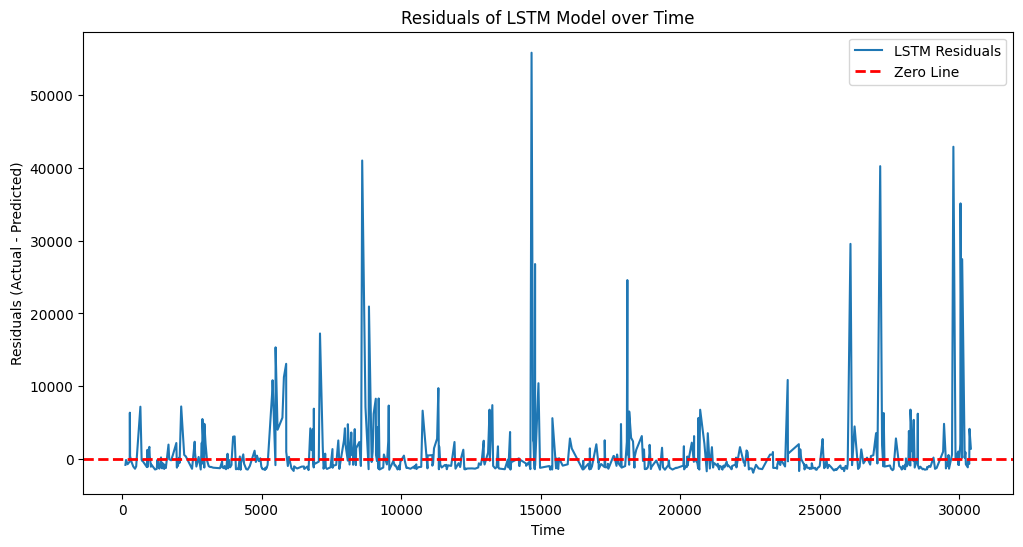

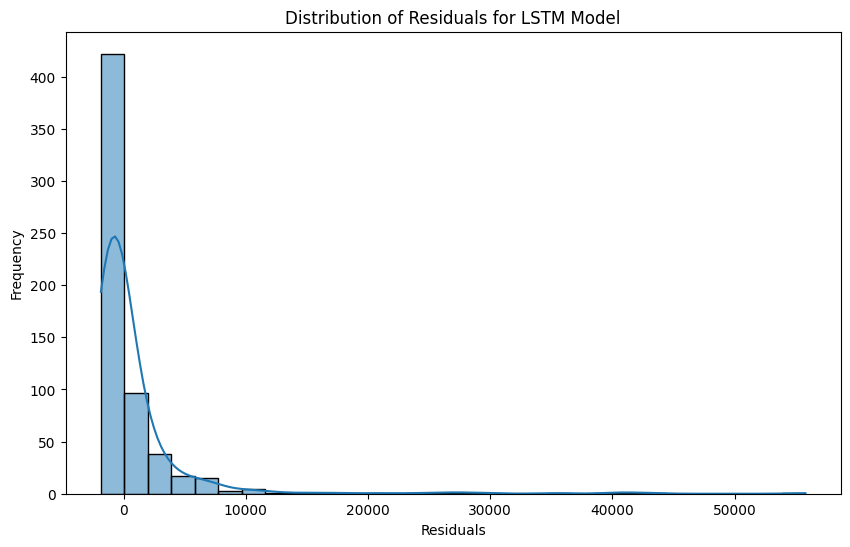

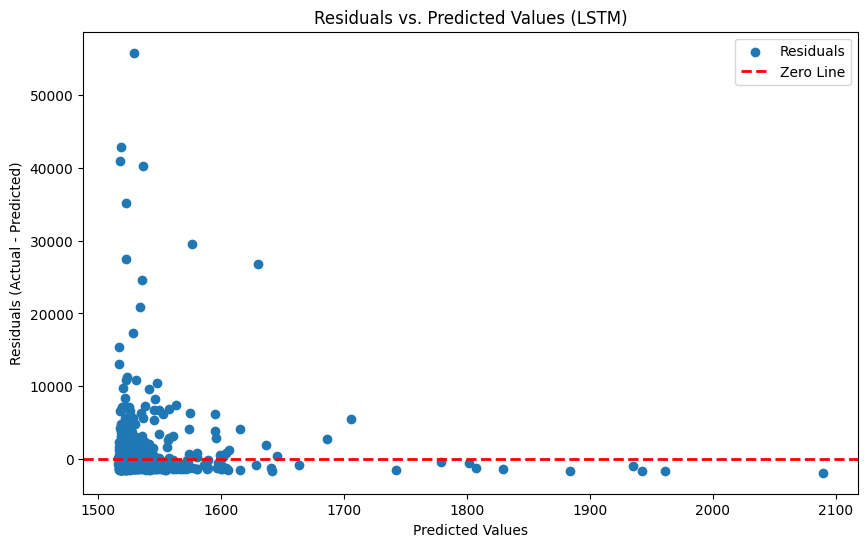

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort test_data_sample by index (time)
test_data_sample = test_data_sample.sort_index()

# Calculate residuals for LSTM (can do the same for ARIMA, XGBoost)
residuals_lstm = test_data_sample['total_sales'] - lstm_forecast

# Plot 1: Residuals over time with a legend
plt.figure(figsize=(12, 6))
plt.plot(test_data_sample.index, residuals_lstm, label='LSTM Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Line')
plt.title('Residuals of LSTM Model over Time')
plt.xlabel('Time')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()  # Add legend here
plt.show()

# Plot 2: Histogram of residuals with KDE plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals_lstm, kde=True, bins=30)
plt.title('Distribution of Residuals for LSTM Model')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
# No need for a legend here, as it's a single distribution
plt.show()

# Plot 3: Residuals vs. Predicted values with a legend
plt.figure(figsize=(10, 6))
plt.scatter(lstm_forecast, residuals_lstm, label='Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Line')
plt.title('Residuals vs. Predicted Values (LSTM)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()  # Add legend here
plt.show()

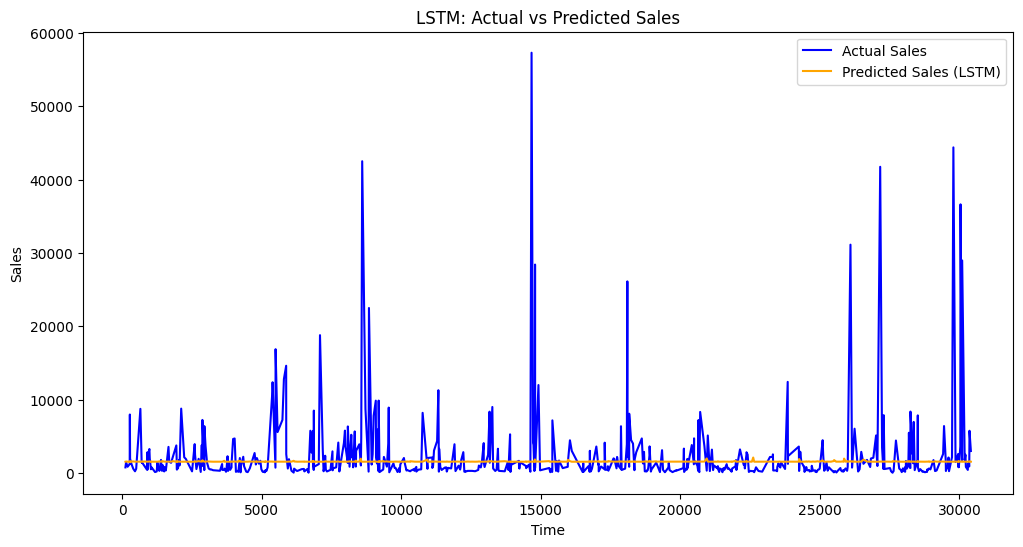

In [117]:
# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))

# Plot actual sales
plt.plot(test_data_sample.index, test_data_sample['total_sales'], label='Actual Sales', color='blue')

# Plot predicted sales from LSTM
plt.plot(test_data_sample.index, lstm_forecast, label='Predicted Sales (LSTM)', color='orange')

# Adding plot titles and labels
plt.title('LSTM: Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

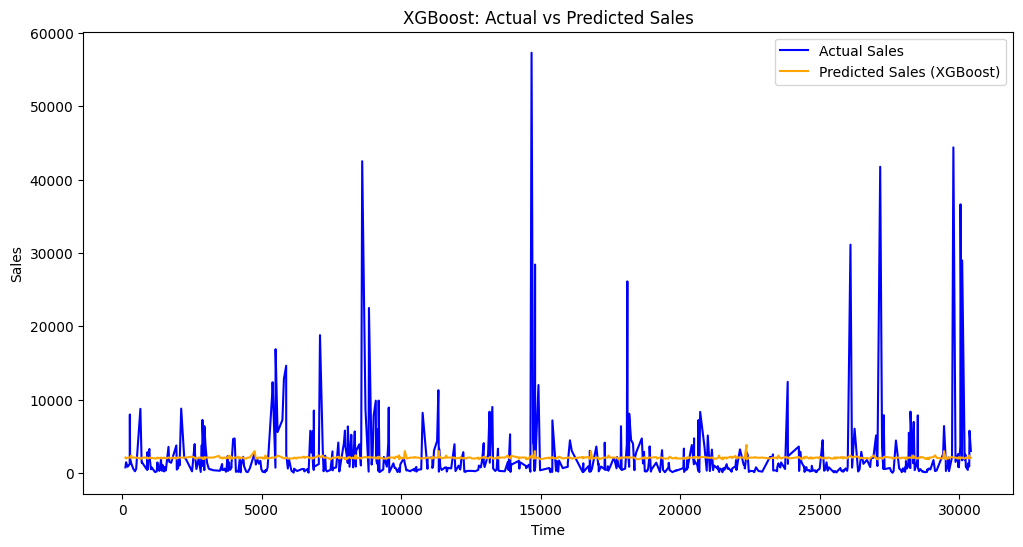

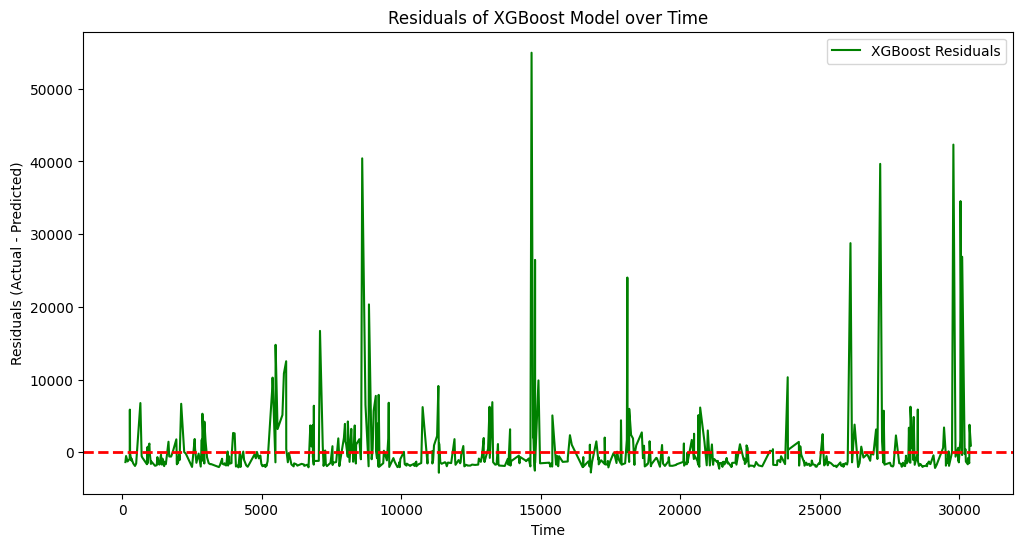

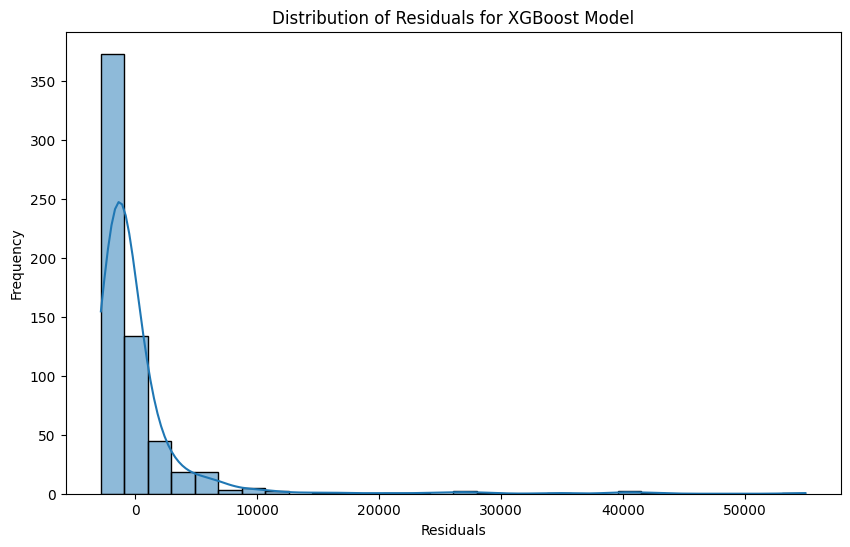

In [126]:
#XGBoost Plots
from xgboost import plot_importance

# Predict using the XGBoost model (assuming `best_xgb_model` from your grid search)
xgb_forecast_tuned = best_xgb_model.predict(X_test_xgb)

# 1. Plot Actual vs Predicted Values over Time
plt.figure(figsize=(12, 6))
plt.plot(test_data_sample.index, test_data_sample['total_sales'], label='Actual Sales', color='blue')
plt.plot(test_data_sample.index, xgb_forecast_tuned, label='Predicted Sales (XGBoost)', color='orange')
plt.title('XGBoost: Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# 2. Plot Residuals (Actual - Predicted) over Time
residuals_xgb = test_data_sample['total_sales'] - xgb_forecast_tuned

plt.figure(figsize=(12, 6))
plt.plot(test_data_sample.index, residuals_xgb, label='XGBoost Residuals', color='green')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals of XGBoost Model over Time')
plt.xlabel('Time')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

# Plot 2: Histogram of residuals with KDE plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals_xgb, kde=True, bins=30)
plt.title('Distribution of Residuals for XGBoost Model')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
# No need for a legend here, as it's a single distribution
plt.show()

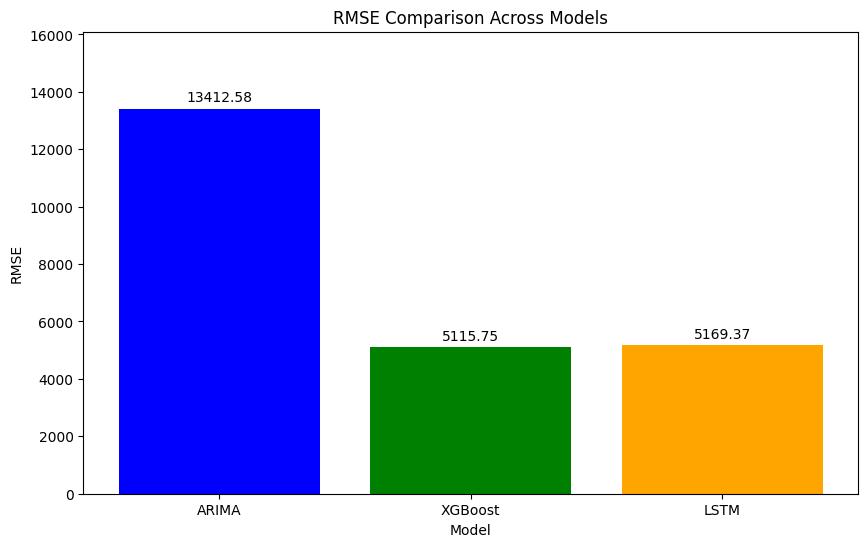

In [127]:
# Assume the RMSE values have already been calculated as:
rmse_arima = np.sqrt(mean_squared_error(test_data_sample['total_sales'], arima_forecast))
rmse_xgb = np.sqrt(mean_squared_error(test_data_sample['total_sales'], xgb_forecast_tuned))
rmse_lstm = np.sqrt(mean_squared_error(test_data_sample['total_sales'], lstm_forecast))


# List of model names and their corresponding RMSE values
models = ['ARIMA', 'XGBoost', 'LSTM']
rmse_values = [rmse_arima, rmse_xgb, rmse_lstm]

# Plotting RMSE comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color=['blue', 'green', 'orange'])

# Add titles and labels
plt.title('RMSE Comparison Across Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.ylim(0, max(rmse_values) * 1.2)  # Add some padding above the max RMSE value

# Display RMSE values on top of bars
for i, v in enumerate(rmse_values):
    plt.text(i, v + 0.01 * max(rmse_values), f'{v:.2f}', ha='center', va='bottom')

# Show the plot
plt.show()
